In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline

path = '/Users/chris/Desktop/mastrangelo/'


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

k = pd.Series([833, 134, 38, 15, 5, 0])

In [3]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [4]:
truth = pd.read_csv(path+'collect_ground_truth.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'collect_recovery.csv', converters=dict(transit_multiplicities=literal_eval))


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = truth.loc[(truth.ms == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logLs))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

#### Quality control

With so many records, some of them get corrupted. There are several ways we can deal with this, but since each model has 30 random samples, a corrupted record will simply be dropped. Therefore, later on, rather than summing to marginalize the log likelihoods, we take the mean. 

In [46]:
# retrieve indices of rows that somehow got padded with many extra bins
long_indices = recovery.loc[recovery['transit_multiplicities'].str.len() > 6]['transit_multiplicities'].index

# drop these rows
recovery = recovery.drop(long_indices)

In [5]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [6]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


Prepare machinery for injection-recovery experiments

In [6]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-1,0,6)[gi_m] 
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [7]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

What would it look like to take the logL of something that's sqrt(N) deviated from the ground truth, where N is the number of systems in each bin? 

Answer: this is $\Delta$ logL of 3 different from the perfect case of comparing the ground truth to itself.

In [8]:
better_loglike(np.array([9900, 804, 122, 32, 11, 3, 0]), np.array([1e4, 833, 134, 38, 15, 5, 0]))

-23.261564101898227

In [79]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (heavy sculpting model)

In [517]:
tm_fiducial = truth.loc[(truth.ms == -1.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

692    [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]
Name: transit_multiplicities, dtype: object

In [518]:
test_recovery = recovery.loc[(recovery.ms == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]


Let's quickly check their transit yields to see whether they make sense.

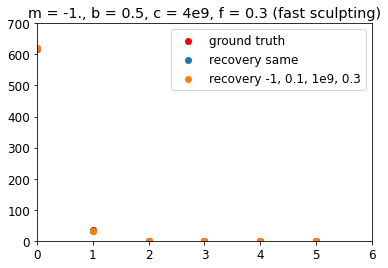

In [519]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[20760].transit_multiplicities)), recovery.iloc[20760].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

This makes sense: the yields between higher b but short-lived sculpting and lower b but longer-lived sculpting are similar.

In [520]:
def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2] # // is floor division

In [528]:
cube

[0.0, 1.0, 10000000000.0]

In [521]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # take the median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                

In [522]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'injection_transit_multiplicities': all_transit_multiplicities, 
                            'logL': all_logLs})
model_logLs

,m,b,c,f,injection_transit_multiplicities,logL
0,-1.0,0.0,1.000000e+08,0.1,"[202.70000000000002, 12.200000000000001, 0.0, ...",-292.656186
1,-1.0,0.0,1.000000e+08,0.2,"[408.6, 23.6, 0.0, 0.0, 0.0, 0.0]",-55.465881
2,-1.0,0.0,1.000000e+08,0.3,"[611.1, 31.2, 0.0, 0.0, 0.0, 0.0]",-7.061195
3,-1.0,0.0,1.000000e+08,0.4,"[810.8000000000001, 48.800000000000004, 0.0, 0...",-35.019123
4,-1.0,0.0,1.000000e+08,0.5,"[1013.5, 61.0, 0.0, 0.0, 0.0, 0.0]",-105.185728
...,...,...,...,...,...,...
7255,0.0,1.0,1.000000e+10,0.6,"[1386.0, 706.8, 381.59999999999997, 157.799999...",-1424.313592
7256,0.0,1.0,1.000000e+10,0.7,"[1696.1, 812.0, 420.7, 168.0, 49.0, 4.19999999...",-1774.311494
7257,0.0,1.0,1.000000e+10,0.8,"[1938.4, 928.0, 480.8, 192.0, 56.0, 4.80000000...",-2138.092498
7258,0.0,1.0,1.000000e+10,0.9,"[2180.7000000000003, 1044.0, 540.9, 216.0, 63....",-2511.580396


### Note that while these logLs take f into account, they do not take the zero-bin into account. analyze.ipynb has machinery to handle that, and we can do this injection-recovery routine with those logLs instead, if we want. 

#### What is the $\Delta$ logL between the very best model and the ground truth?

Identify best and good models

In [206]:
x = np.logspace(8, 10, 1000)

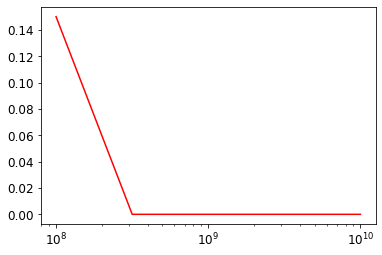

In [207]:
ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
plt.xscale('log')


In [523]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -1.) & (np.round(recovery.bs,1) == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)].logLs)
print("delta logL: ", delta_logL)

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f   injection_transit_multiplicities     logL
1312 -0.8  0.0  1.000000e+10  0.3  [621.9, 32.4, 0.0, 0.0, 0.0, 0.0] -6.95384
Ground truth:         m    b             c    f   injection_transit_multiplicities      logL
632 -1.0  0.5  3.981072e+09  0.3  [621.0, 34.5, 0.3, 0.6, 0.0, 0.0] -7.784932
delta logL:  19.563412900262612
Some models between best model and ground truth: 
      m    b            c    f  \
2  -1.0  0.0  100000000.0  0.3   
12 -1.0  0.0  158489319.0  0.3   
22 -1.0  0.0  251188643.0  0.3   
32 -1.0  0.0  398107171.0  0.3   
42 -1.0  0.0  630957344.0  0.3   

                   injection_transit_multiplicities      logL  
2                 [611.1, 31.2, 0.0, 0.0, 0.0, 0.0] -7.061195  
12  [625.5, 31.799999999999997, 0.0, 0.0, 0.0, 0.0] -7.033363  
22                [630.0, 36.0, 0.0, 0.0, 0.0, 0.0] -6.994674  
32  [616.5, 38.699999999999996, 0.0, 0.0, 0.0, 0.0] -7.040230  
42                [604.5, 37.5, 0.0, 0.0, 0.0, 0.0] -

In [ ]:
recovery.loc[(np.round(recovery.ms, 1) == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]

Hold on: why are there multiple best models? EDIT 1: It seems like some data swapping happened when the simulations were made. So, I have to identify the real one and then drop the other rows. EDIT 2: Maybe the sure-fire way is to re-draw a simulation with my unit test script and see how close it gets to the apparently-copied data? EDIT 3: This problem went away when I went from taking the best logL per 30 draws of a model, to taking the median logL per 30 draws of a model.

In [176]:
model_logLs.iloc[1380:1390] # this is the right one

,m,b,c,f,injection_transit_multiplicities,logL
1380,-0.8,0.1,1.584893e+09,0.1,"[214.20000000000002, 11.3, 0.0, 0.0, 0.0, 0.0]",-271.902638
1381,-0.8,0.1,1.584893e+09,0.2,"[428.40000000000003, 22.6, 0.0, 0.0, 0.0, 0.0]",-45.955880
1382,-0.8,0.1,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1383,-0.8,0.1,1.584893e+09,0.4,"[778.4000000000001, 38.400000000000006, 0.0, 0...",-25.144699
1384,-0.8,0.1,1.584893e+09,0.5,"[973.0, 48.0, 0.0, 0.0, 0.0, 0.0]",-84.011304
1385,-0.8,0.1,1.584893e+09,0.6,"[1167.6, 57.599999999999994, 0.0, 0.0, 0.0, 0.0]",-169.465274
1386,-0.8,0.1,1.584893e+09,0.7,"[1362.1999999999998, 67.19999999999999, 0.0, 0...",-273.266936
1387,-0.8,0.1,1.584893e+09,0.8,"[1556.8000000000002, 76.80000000000001, 0.0, 0...",-390.497940
1388,-0.8,0.1,1.584893e+09,0.9,"[1751.4, 86.4, 0.0, 0.0, 0.0, 0.0]",-517.985849
1389,-0.8,0.1,1.584893e+09,1.0,"[1946.0, 96.0, 0.0, 0.0, 0.0, 0.0]",-653.564545


In [177]:
model_logLs.iloc[1490:1500]

,m,b,c,f,injection_transit_multiplicities,logL
1490,-0.8,0.2,1.584893e+09,0.1,"[214.8, 11.700000000000001, 0.1, 0.1, 0.0, 0.0]",-270.167605
1491,-0.8,0.2,1.584893e+09,0.2,"[429.6, 23.400000000000002, 0.2, 0.2, 0.0, 0.0]",-45.420846
1492,-0.8,0.2,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1493,-0.8,0.2,1.584893e+09,0.4,"[780.0, 50.0, 0.4, 0.4, 0.0, 0.0]",-28.692784
1494,-0.8,0.2,1.584893e+09,0.5,"[975.0, 62.5, 0.5, 0.5, 0.0, 0.0]",-91.059389
1495,-0.8,0.2,1.584893e+09,0.6,"[1170.0, 75.0, 0.6, 0.6, 0.0, 0.0]",-180.013359
1496,-0.8,0.2,1.584893e+09,0.7,"[1365.0, 87.5, 0.7, 0.7, 0.0, 0.0]",-287.315021
1497,-0.8,0.2,1.584893e+09,0.8,"[1560.0, 100.0, 0.8, 0.8, 0.0, 0.0]",-408.046025
1498,-0.8,0.2,1.584893e+09,0.9,"[1755.0, 112.5, 0.9, 0.9, 0.0, 0.0]",-539.033934
1499,-0.8,0.2,1.584893e+09,1.0,"[1950.0, 125.0, 1.0, 1.0, 0.0, 0.0]",-678.112630


In [178]:
model_logLs.iloc[3750:3760]

,m,b,c,f,injection_transit_multiplicities,logL
3750,-0.4,0.1,158489319.0,0.1,"[214.9, 14.5, 1.3, 0.4, 0.4, 0.0]",-267.213979
3751,-0.4,0.1,158489319.0,0.2,"[429.8, 29.0, 2.6, 0.8, 0.8, 0.0]",-47.267220
3752,-0.4,0.1,158489319.0,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
3753,-0.4,0.1,158489319.0,0.4,"[784.0, 47.6, 0.4, 0.0, 0.0, 0.0]",-28.451144
3754,-0.4,0.1,158489319.0,0.5,"[980.0, 59.5, 0.5, 0.0, 0.0, 0.0]",-91.117750
3755,-0.4,0.1,158489319.0,0.6,"[1176.0, 71.39999999999999, 0.6, 0.0, 0.0, 0.0]",-180.371720
3756,-0.4,0.1,158489319.0,0.7,"[1372.0, 83.3, 0.7, 0.0, 0.0, 0.0]",-287.973382
3757,-0.4,0.1,158489319.0,0.8,"[1568.0, 95.2, 0.8, 0.0, 0.0, 0.0]",-409.004386
3758,-0.4,0.1,158489319.0,0.9,"[1764.0, 107.10000000000001, 0.9, 0.0, 0.0, 0.0]",-540.292295
3759,-0.4,0.1,158489319.0,1.0,"[1960.0, 119.0, 1.0, 0.0, 0.0, 0.0]",-679.670991


In [179]:
model_logLs.iloc[3840:3850]

,m,b,c,f,injection_transit_multiplicities,logL
3840,-0.4,0.1,1.000000e+10,0.1,"[215.3, 9.600000000000001, 0.1, 0.0, 0.0, 0.0]",-273.918552
3841,-0.4,0.1,1.000000e+10,0.2,"[423.40000000000003, 24.8, 0.2, 0.0, 0.0, 0.0]",-47.360875
3842,-0.4,0.1,1.000000e+10,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
3843,-0.4,0.1,1.000000e+10,0.4,"[784.0, 47.6, 0.4, 0.0, 0.0, 0.0]",-28.451144
3844,-0.4,0.1,1.000000e+10,0.5,"[980.0, 59.5, 0.5, 0.0, 0.0, 0.0]",-91.117750
3845,-0.4,0.1,1.000000e+10,0.6,"[1176.0, 71.39999999999999, 0.6, 0.0, 0.0, 0.0]",-180.371720
3846,-0.4,0.1,1.000000e+10,0.7,"[1372.0, 83.3, 0.7, 0.0, 0.0, 0.0]",-287.973382
3847,-0.4,0.1,1.000000e+10,0.8,"[1568.0, 95.2, 0.8, 0.0, 0.0, 0.0]",-409.004386
3848,-0.4,0.1,1.000000e+10,0.9,"[1764.0, 107.10000000000001, 0.9, 0.0, 0.0, 0.0]",-540.292295
3849,-0.4,0.1,1.000000e+10,1.0,"[1960.0, 119.0, 1.0, 0.0, 0.0, 0.0]",-679.670991


Let's drop the three likely bad data and find the best and good models again.

In [180]:
"""
model_logLs = model_logLs.drop([1492, 3752, 3842])

best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
#delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (np.round(model_logLs.b,1) == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)
"""

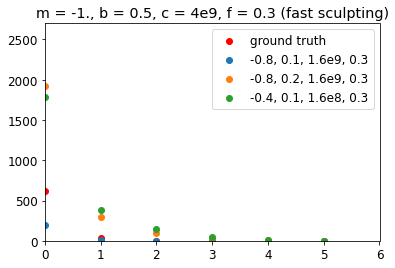

In [210]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[6909].transit_multiplicities)), recovery.iloc[6909].transit_multiplicities, label='-0.8, 0.1, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[7459].transit_multiplicities)), recovery.iloc[7459].transit_multiplicities, label='-0.8, 0.2, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[18759].transit_multiplicities)), recovery.iloc[18759].transit_multiplicities, label='-0.4, 0.1, 1.6e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,2700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

The green functional no-sculpting model has 6.5% multi:single ratio; compared to the blue sculpting model with 5.8% multi:single ratio, this is sensible.

Plot these models

-0.8 0.0 10000000000.0 0.3
-1.0 0.5 3981071706.0 0.3


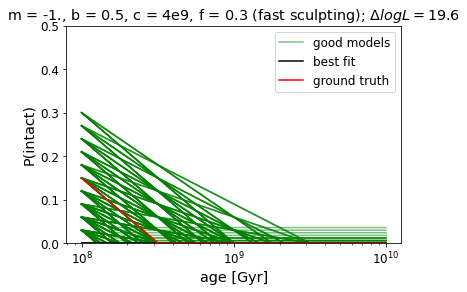

In [527]:
# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL,1)}$')
plt.legend()
plt.savefig(path+'figures/inj-rec-fast-models.png', facecolor='white', bbox_inches='tight')
plt.show()

#### Normalizing no-sculpting models, which are fewer than the others

In [30]:
model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.f == 0.1)]

,m,b,c,f,logL
30250,0.0,0.0,1.000000e+08,0.1,-276.863070
30251,0.0,0.0,1.000000e+08,0.1,-276.863070
30252,0.0,0.0,1.000000e+08,0.1,-276.863070
30300,0.0,0.0,1.584893e+08,0.1,-271.592268
30301,0.0,0.0,1.584893e+08,0.1,-271.592268
...,...,...,...,...,...
36201,0.0,1.0,6.309573e+09,0.1,-335.635030
36202,0.0,1.0,6.309573e+09,0.1,-335.635030
36250,0.0,1.0,1.000000e+10,0.1,-332.059695
36251,0.0,1.0,1.000000e+10,0.1,-332.059695


Ope! Looks like I've lost a few differing cutoff timescale files for the case of no sculpting. Fortunately, this edge case means that the logL should be the same regardless of cutoff time. 

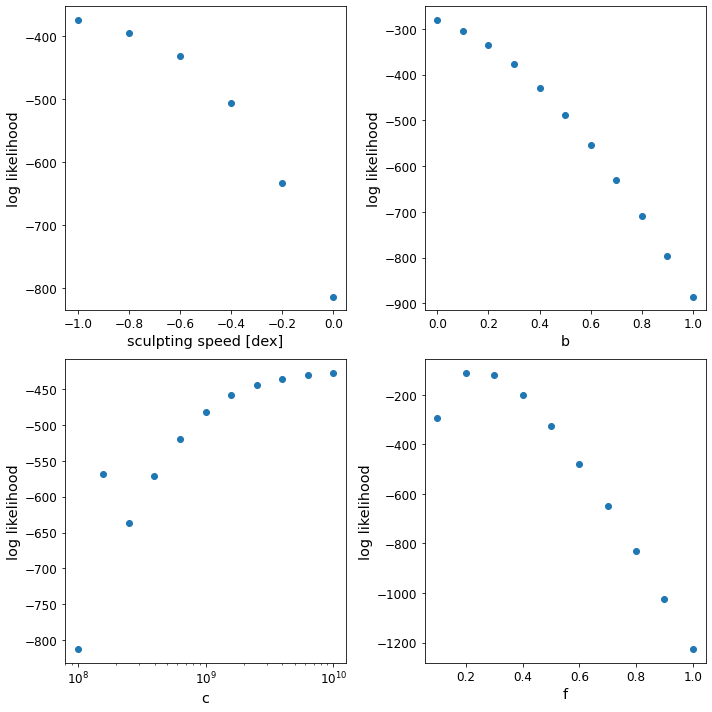

In [430]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(model_logLs.m.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(model_logLs.c.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

In [192]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL.mean())
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL.mean())


-392.3885850797899
-595.5360074768579


It seems like no matter the ground truth, I always favor the second cutoff threshold. Why is that? This subset of models has the same number of records (eg. no dropped data) and similar mins and maxes to adjacent models (ie. the subsequent cutoff threshold of 2.5e8 yrs). So, what gives? 

     m    b            c    f  \
0 -1.0  0.0  100000000.0  0.1   
1 -1.0  0.0  100000000.0  0.2   
2 -1.0  0.0  100000000.0  0.3   
3 -1.0  0.0  100000000.0  0.4   
4 -1.0  0.0  100000000.0  0.5   

                    injection_transit_multiplicities        logL  
0  [202.70000000000002, 12.200000000000001, 0.0, ... -292.656186  
1                  [408.6, 23.6, 0.0, 0.0, 0.0, 0.0]  -55.465881  
2                  [611.1, 31.2, 0.0, 0.0, 0.0, 0.0]   -7.061195  
3  [810.8000000000001, 48.800000000000004, 0.0, 0...  -35.019123  
4                 [1013.5, 61.0, 0.0, 0.0, 0.0, 0.0] -105.185728  


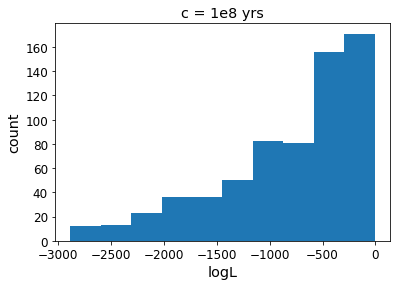

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                   injection_transit_multiplicities        logL  
10                [205.0, 10.9, 0.0, 0.0, 0.0, 0.0] -290.943922  
11                [410.0, 21.8, 0.0, 0.0, 0.0, 0.0]  -55.247164  
12  [625.5, 31.799999999999997, 0.0, 0.0, 0.0, 0.0]   -7.033363  
13  [819.6, 42.800000000000004, 0.0, 0.0, 0.0, 0.0]  -35.300405  
14               [1024.5, 53.5, 0.0, 0.0, 0.0, 0.0] -105.717010  


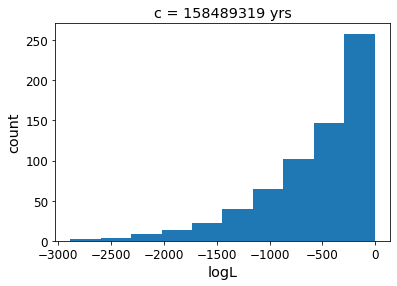

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                   injection_transit_multiplicities        logL  
20                [205.0, 10.5, 0.0, 0.0, 0.0, 0.0] -292.136830  
21                [410.0, 21.0, 0.0, 0.0, 0.0, 0.0]  -55.890072  
22                [630.0, 36.0, 0.0, 0.0, 0.0, 0.0]   -6.994674  
23  [809.2, 50.400000000000006, 0.0, 0.0, 0.0, 0.0]  -34.843313  
24               [1011.5, 63.0, 0.0, 0.0, 0.0, 0.0] -104.709918  


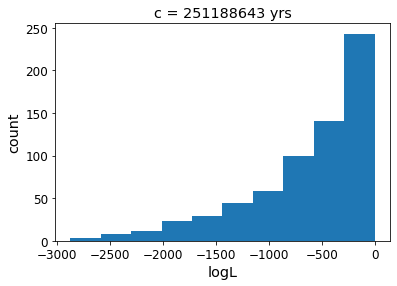

In [429]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


In [486]:
import matplotlib.ticker as tick

def y_fmt(x, y):
    return '{:2.2e}'.format(x).replace('e', 'x10^')
    #return 

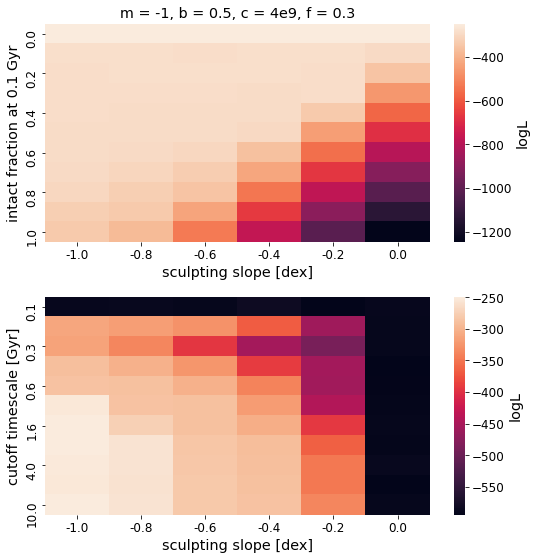

In [500]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

### 1
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood

#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax1)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('m = -1, b = 0.5, c = 4e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')

### 2
piv = model_logLs.groupby(['m','c']).median('logL').reset_index()
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax2)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))

plt.savefig(path+'figures/inj-rec-fast-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

Here's the old way, in case I need to return to it.

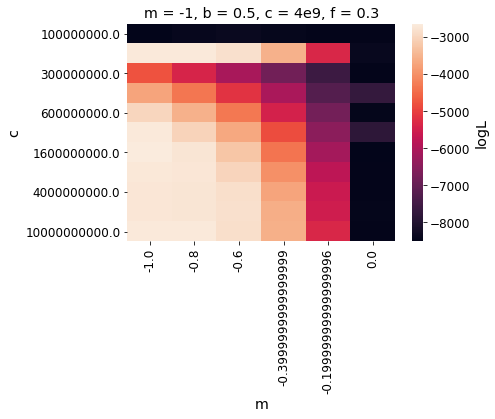

In [37]:
"""
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()
"""

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

The mystery around why the models seem to love the second cutoff threshold continues to deepen, as I show in the first three attached plots for the fake ground truth of fast sculpting (m = -1, b = 0.5, c = 4e9, f = 0.3). The middle plot of 1.6e8 years shows a shorter tail than the adjacent cutoff times. 

EDIT: Actually, I don’t think this is as big a mystery as it seemed; as shown by the two other ground truths below. The only question is why all three ground truths favor a cutoff time that is way younger than the median age of the stellar sample…which suggests that no matter what’s real, sculpting is always going to appear to be very short-lived.

I am also finding that when I examine the raw simulation outputs from HPG, sometimes some models get the exact same transit multiplicity. Either this is some coincidence, or some as yet undiscovered bug, or some copying of data happened in the distributed HPG job. This happens only a few times, as far as I can tell. My ad hoc solution is to manually identify the original correct record and drop the incorrect ones, but I can only identify them as they come to my attention (which is when a spuriously copied multiplicity happens to be better than the other 29 draws and elevates a model beyond where it should be). I have switched to taking the median out of each 30ish samples instead of the max, and that seems to be a little more robust, but the weird favoring of the second cutoff time still persists.

Finally, the ground truth plot says a cutoff of 4e9, but since that model’s slope takes us below zero well before then, that is as good as any model with a cutoff time after that zero point. So, perhaps I should have chosen a more sensible ground truth.

#### Model 3: m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)


Before we proceed, let's take a detour to check that the transit multiplicity yields for different models are different in the ways that we expect. For example, a model with more sculpting and/or fewer initially intact systems should have fewer multis.

In [501]:
tm_fiducial = truth.loc[(truth.ms == -0.6) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

3902    [676.5, 162.9, 71.1, 29.7, 7.199999999999999, ...
Name: transit_multiplicities, dtype: object

In [502]:
test_recovery = recovery.loc[(recovery.ms == -0.6) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities

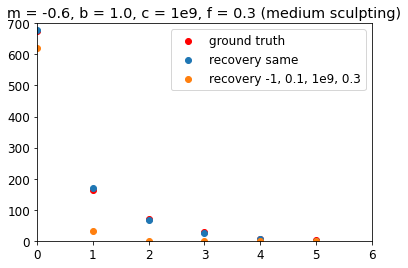

In [503]:
plt.scatter(np.arange(len(tm_fiducial[3902])), tm_fiducial[3902], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[117060].transit_multiplicities)), recovery.iloc[117060].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)')
plt.legend()
plt.show()

Both in count and relative to singles, there are fewer multis represented by the orange dots than the blue/red dots. Anyway, let's continue to check out injection-recovery for medium sculpting models.

In [504]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

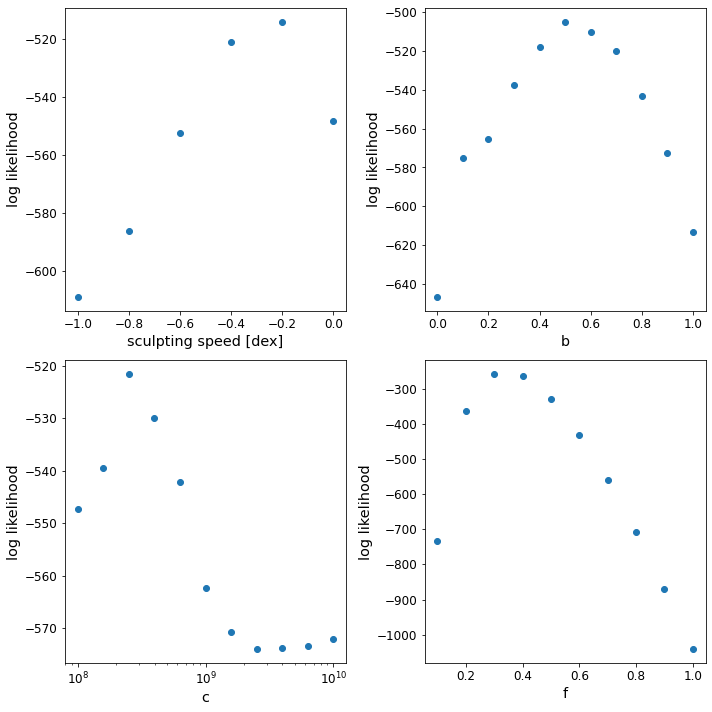

In [505]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

Second cutoff threshold mystery continues...

     m    b            c    f                                  tm        logL
0 -1.0  0.0  100000000.0  0.1   [202.3, 12.0, 0.0, 0.0, 0.0, 0.0] -942.060698
1 -1.0  0.0  100000000.0  0.2   [408.6, 23.6, 0.0, 0.0, 0.0, 0.0] -574.374273
2 -1.0  0.0  100000000.0  0.3   [608.1, 36.6, 0.0, 0.0, 0.0, 0.0] -447.168254
3 -1.0  0.0  100000000.0  0.4   [829.6, 49.6, 0.0, 0.0, 0.0, 0.0] -421.212884
4 -1.0  0.0  100000000.0  0.5  [1004.0, 57.0, 0.0, 0.0, 0.0, 0.0] -451.194275


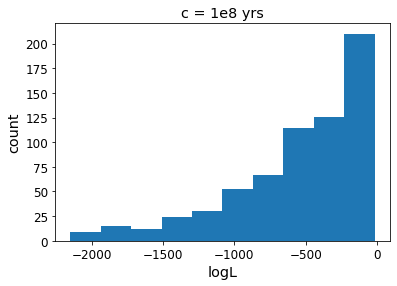

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                                                   tm        logL  
10                  [208.3, 10.8, 0.0, 0.0, 0.0, 0.0] -945.077538  
11                  [391.6, 24.8, 0.0, 0.0, 0.0, 0.0] -579.261919  
12                  [600.9, 34.5, 0.0, 0.0, 0.0, 0.0] -455.011143  
13  [852.4000000000001, 48.800000000000004, 0.0, 0... -428.066720  
14                 [1041.5, 62.5, 0.0, 0.0, 0.0, 0.0] -455.463465  


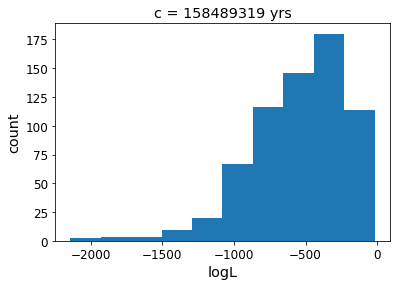

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                                                   tm        logL  
20  [204.10000000000002, 11.600000000000001, 0.0, ... -943.112697  
21     [394.40000000000003, 25.0, 0.0, 0.0, 0.0, 0.0] -576.118511  
22                  [575.4, 36.3, 0.0, 0.0, 0.0, 0.0] -452.102804  
23  [810.4000000000001, 46.400000000000006, 0.0, 0... -425.930211  
24                 [1044.5, 64.0, 0.0, 0.0, 0.0, 0.0] -453.947652  


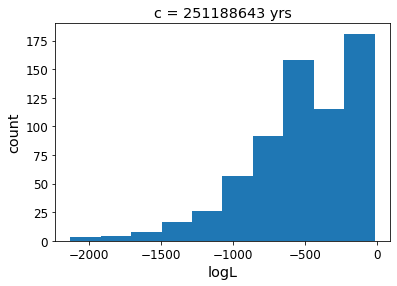

In [506]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


The former distribution does seem to have a shorter tail than the latter. We will revisit this for other ground truths.

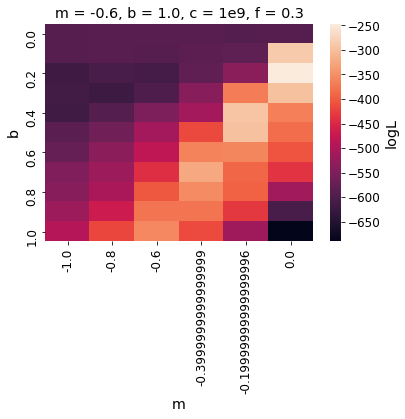

In [375]:
""""
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()
"""

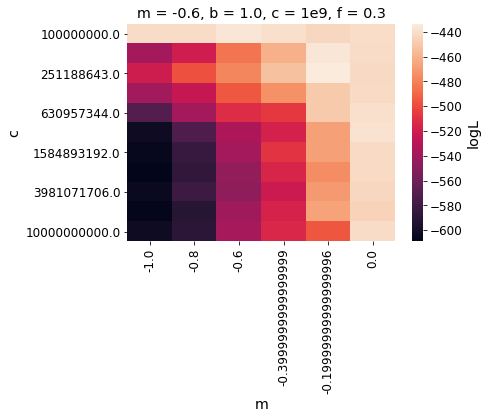

In [376]:
"""piv = model_logLs.groupby(['m','c']).median('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()
"""

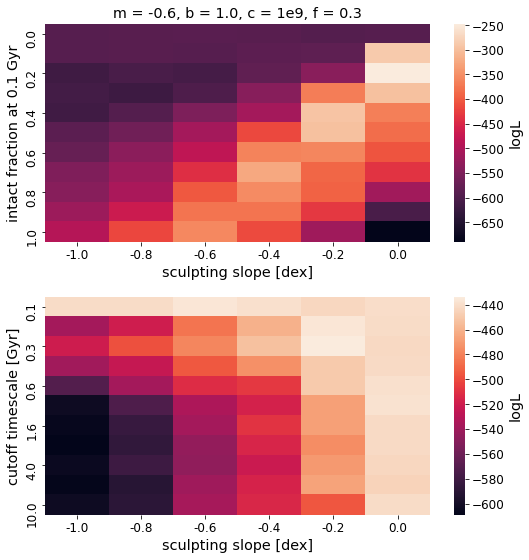

In [507]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

### 1
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood

#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax1)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')

### 2
piv = model_logLs.groupby(['m','c']).median('logL').reset_index()
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax2)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))

plt.savefig(path+'figures/inj-rec-moderate-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

1D posteriors show that I can recover m and c, but not quite f and definitely not b. 2D posteriors corroborate this for m and b, and they suggest that there are fast sculpting models with even shorter cutoff times that are also favored. 

Identify best and good models

In [508]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -0.6) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
#delta_logL = best_logL - ground_truth.logL.to_list()[0]
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -0.6) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].logLs)

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models)

Best model:         m    b            c    f  \
442 -1.0  0.4  100000000.0  0.3   

                                                    tm       logL  
442  [655.1999999999999, 170.4, 66.89999999999999, ... -17.294089  
Ground truth:          m    b             c    f                                    tm  \
3572 -0.6  1.0  1.000000e+09  0.3  [677.4, 171.0, 66.6, 25.8, 6.6, 0.6]   

           logL  
3572 -17.553282  
Some models between best model and ground truth: 
        m    b             c    f  \
442  -1.0  0.4  1.000000e+08  0.3   
552  -1.0  0.5  1.000000e+08  0.3   
902  -1.0  0.8  2.511886e+08  0.3   
1012 -1.0  0.9  2.511886e+08  0.3   
1132 -1.0  1.0  3.981072e+08  0.3   
...   ...  ...           ...  ...   
6652  0.0  0.5  1.000000e+09  0.3   
6662  0.0  0.5  1.584893e+09  0.3   
6672  0.0  0.5  2.511886e+09  0.3   
6682  0.0  0.5  3.981072e+09  0.3   
6692  0.0  0.5  6.309573e+09  0.3   

                                                     tm       logL  
442   [655.199

Plot these models

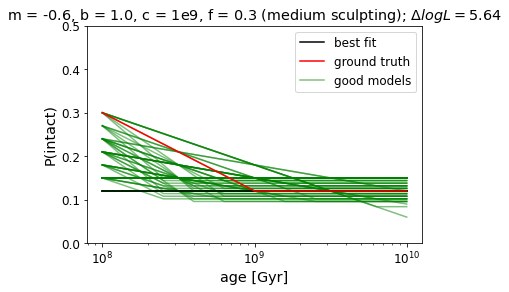

In [509]:
x = np.logspace(8, 10, 1000)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting); $\Delta logL = {np.round(delta_logL, 2)}$')
plt.legend()
plt.savefig(path+'figures/inj-rec-moderate-models.png', facecolor='white', bbox_inches='tight')

plt.show()

#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [382]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

7262    [658.8, 183.0, 85.2, 38.1, 11.4, 2.1]
Name: transit_multiplicities, dtype: object

In [383]:
test_recovery = recovery.loc[(recovery.ms == 0.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)]
#test_recovery

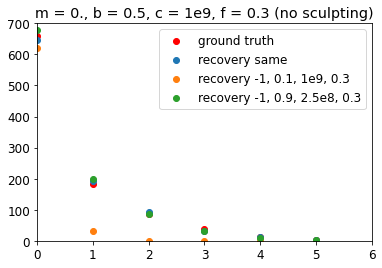

In [384]:
plt.scatter(np.arange(len(tm_fiducial[7262])), tm_fiducial[7262], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[217860].transit_multiplicities)), recovery.iloc[217860].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[33360].transit_multiplicities)), recovery.iloc[33360].transit_multiplicities, label='recovery -1, 0.9, 2.5e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting)')
plt.legend()
plt.show()

In [385]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

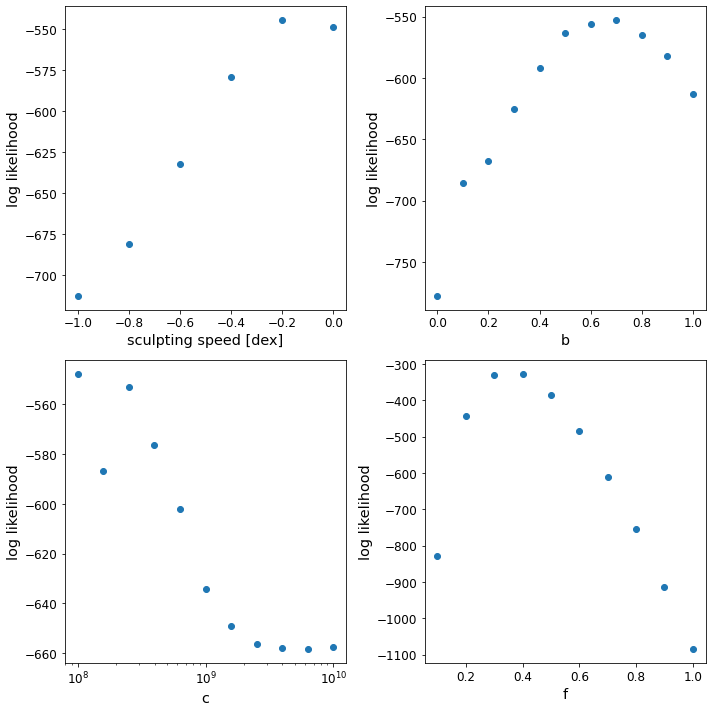

In [386]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

Second cutoff threshold mystery

     m    b            c    f                                  tm         logL
0 -1.0  0.0  100000000.0  0.1   [202.3, 12.0, 0.0, 0.0, 0.0, 0.0] -1075.874264
1 -1.0  0.0  100000000.0  0.2   [397.6, 24.8, 0.0, 0.0, 0.0, 0.0]  -706.331536
2 -1.0  0.0  100000000.0  0.3   [608.1, 36.6, 0.0, 0.0, 0.0, 0.0]  -578.034013
3 -1.0  0.0  100000000.0  0.4   [829.6, 49.6, 0.0, 0.0, 0.0, 0.0]  -551.590149
4 -1.0  0.0  100000000.0  0.5  [1015.0, 59.0, 0.0, 0.0, 0.0, 0.0]  -581.794304


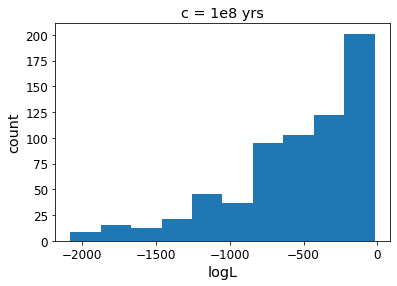

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                                                   tm         logL  
10    [205.9, 11.200000000000001, 0.0, 0.0, 0.0, 0.0] -1079.935210  
11    [395.8, 24.200000000000003, 0.0, 0.0, 0.0, 0.0]  -711.580290  
12                  [622.8, 33.9, 0.0, 0.0, 0.0, 0.0]  -587.682586  
13  [852.4000000000001, 48.800000000000004, 0.0, 0...  -559.431174  
14                 [1003.0, 55.5, 0.0, 0.0, 0.0, 0.0]  -586.835555  


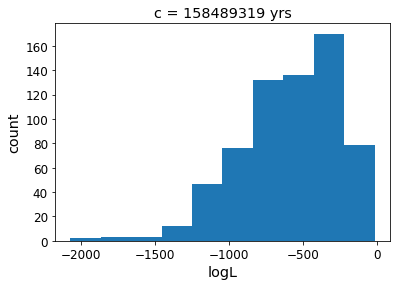

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                                                   tm         logL  
20                  [201.8, 12.0, 0.0, 0.0, 0.0, 0.0] -1077.323469  
21                  [414.6, 22.8, 0.0, 0.0, 0.0, 0.0]  -709.317972  
22                  [575.4, 36.3, 0.0, 0.0, 0.0, 0.0]  -583.143711  
23  [810.4000000000001, 46.400000000000006, 0.0, 0...  -557.189602  
24                 [1013.0, 58.0, 0.0, 0.0, 0.0, 0.0]  -584.129225  


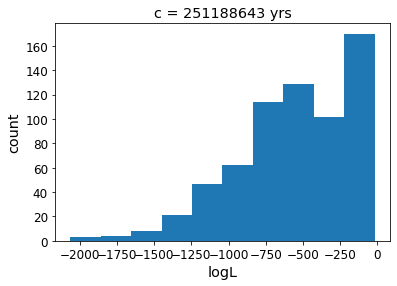

In [387]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


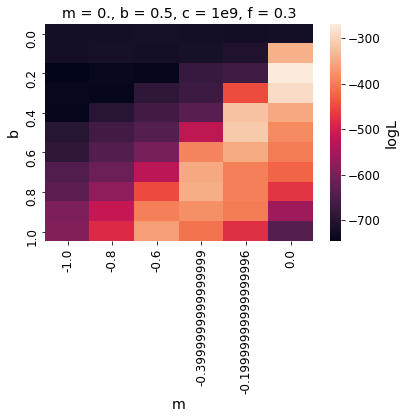

In [388]:
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3')
plt.show()

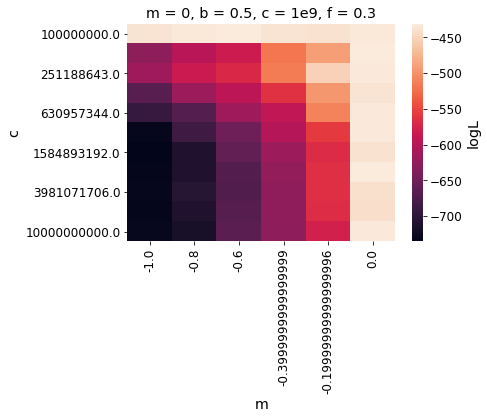

In [389]:
piv = model_logLs.groupby(['m','c']).median('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0, b = 0.5, c = 1e9, f = 0.3')
plt.show()

We get close to recovering the lack of sculpting in the fake ground truth. We somewhat overpredict b and f, and of course c is not a sensible variable in the case of no sculpting. 

Identify best and good models

In [390]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
#delta_logL = best_logL - ground_truth.logL.to_list()[0]
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == 0.) & (np.round(recovery.bs,1) == 0.5) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].logLs)

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f  \
6642  0.0  0.5  630957344.0  0.3   

                                                     tm       logL  
6642  [664.5, 195.0, 81.89999999999999, 31.799999999... -18.430506  
Ground truth:          m    b             c    f  \
6652  0.0  0.5  1.000000e+09  0.3   

                                                     tm       logL  
6652  [673.8, 201.0, 84.0, 32.1, 11.7, 1.79999999999... -18.652577  
Some models between best model and ground truth: 
        m    b            c    f  \
442  -1.0  0.4  100000000.0  0.3   
552  -1.0  0.5  100000000.0  0.3   
902  -1.0  0.8  251188643.0  0.3   
1012 -1.0  0.9  251188643.0  0.3   
1132 -1.0  1.0  398107171.0  0.3   

                                                     tm       logL  
442   [662.1, 171.9, 61.199999999999996, 29.4, 11.7,... -22.919766  
552                [649.5, 191.7, 93.6, 30.9, 9.6, 1.2] -18.965717  
902   [658.5, 164.1, 70.2, 27.0, 9.299999999999999, ... -23.097107  
1012 

In [391]:
good_models

,m,b,c,f,tm,logL
442,-1.0,0.4,1.000000e+08,0.3,"[662.1, 171.9, 61.199999999999996, 29.4, 11.7,...",-22.919766
552,-1.0,0.5,1.000000e+08,0.3,"[649.5, 191.7, 93.6, 30.9, 9.6, 1.2]",-18.965717
902,-1.0,0.8,2.511886e+08,0.3,"[658.5, 164.1, 70.2, 27.0, 9.299999999999999, ...",-23.097107
1012,-1.0,0.9,2.511886e+08,0.3,"[666.3, 207.0, 88.8, 36.6, 12.9, 1.2]",-19.011814
1132,-1.0,1.0,3.981072e+08,0.3,"[675.9, 169.5, 69.6, 26.7, 9.0, 1.2]",-22.150629
...,...,...,...,...,...,...
6662,0.0,0.5,1.584893e+09,0.3,"[670.5, 201.6, 88.5, 38.1, 11.1, 0.89999999999...",-18.825847
6672,0.0,0.5,2.511886e+09,0.3,"[678.0, 183.0, 80.7, 35.1, 10.2, 0.6]",-18.765850
6682,0.0,0.5,3.981072e+09,0.3,"[668.1, 195.9, 96.3, 36.3, 8.1, 1.5]",-18.968825
6692,0.0,0.5,6.309573e+09,0.3,"[669.3, 209.1, 78.6, 37.8, 11.1, 1.79999999999...",-19.190402


Plot these models

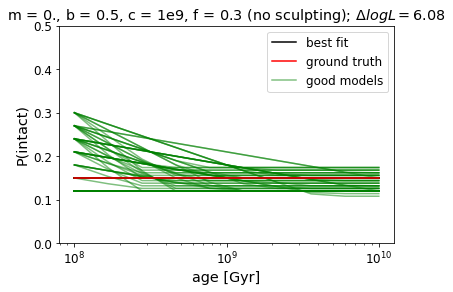

In [392]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

Finally, for the no-sculpting model (m = 0, b = 0.5, c = 1e9, f = 0.3), I get the following plots. The question of why delta logL is so small remains, but again, at least all good models result in roughly the same present-day intact fraction.

Perhaps I need to try a very slow (m=-0.2) and long-lived (c=4e9 yrs or something like that).


#### Model 5: slow sculpting (m=-0.2, b=1.0, c=4e9 yrs, f=0.3)

In [510]:
tm_fiducial = truth.loc[(np.round(truth.ms,1) == -0.2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

6572    [676.5, 250.2, 131.4, 50.699999999999996, 15.0...
Name: transit_multiplicities, dtype: object

In [511]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

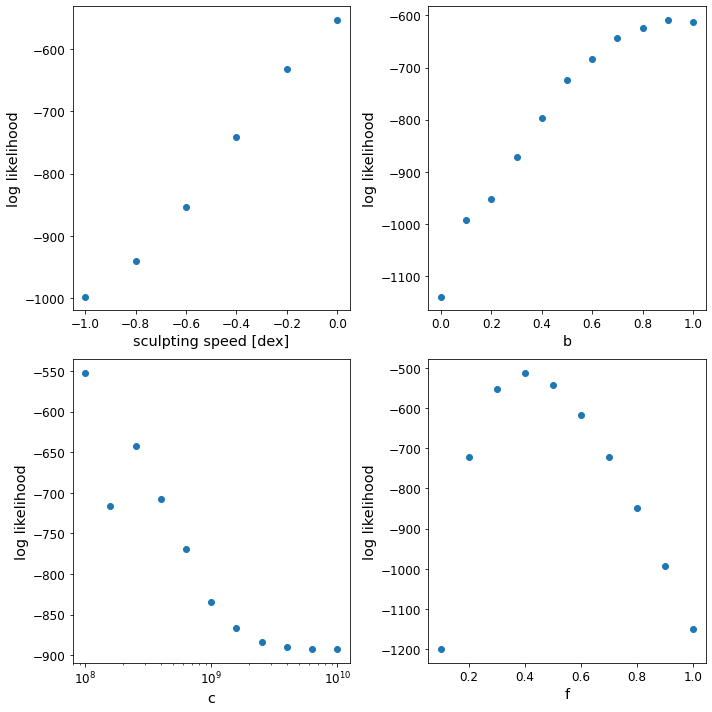

In [512]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.m, 1) == np.round(cube[0], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.b,1) == np.round(cube[1], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.c,0) == np.round(cube[2], 0))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

It appears our framework is indeed insensitive to long sculpting timescales, favoring shorter cutoff thresholds even when the ground truth is ~1 Gyr. Let's do the logL histograms as with the other ground truths to further examine this.

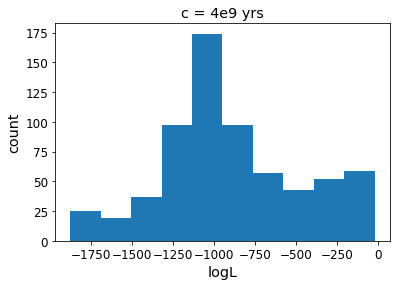

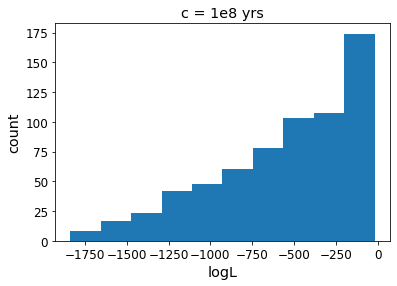

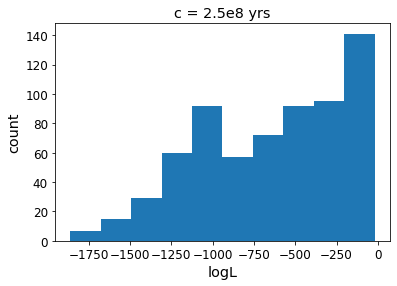

In [513]:
want = model_logLs.loc[(np.round(model_logLs.c, -8) == 4e9)]

plt.hist(want.logL)
plt.title('c = 4e9 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

first_threshold = model_logLs.loc[(np.round(model_logLs.c, -7) == 1e8)]
plt.hist(first_threshold.logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

third_threshold = model_logLs.loc[(np.round(model_logLs.c, -7) == 2.5e8)]
plt.hist(third_threshold.logL)
plt.title('c = 2.5e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

Indeed, the long ground truth sculpting timescale peaks at -1000 logL, versus the shorter timescales that peak close to 0. Perhaps the log spacing convolved with the age distribution of the stellar sample means that longer timescales are always playing a losing game, in which marginalizing over 1D penalizes slow sculpting and/or high initial intact fractions by lumping them in with moderate and faster sculpting, which exert oversized influence over very long (Gyr+) timescales. So, let's examine the 2D marginalized likelihoods.

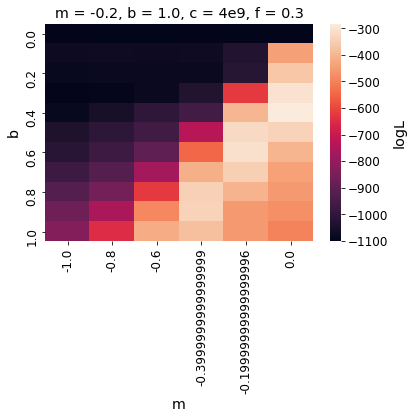

In [354]:
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
plt.show()

In [356]:
test_recovery1 = model_logLs.loc[(np.round(model_logLs.m,1) == -0.2) & (model_logLs.b == 1.) ]
print(test_recovery1.logL.median())
test_recovery2 = model_logLs.loc[(np.round(model_logLs.m,1) == -0.2) & (model_logLs.b == 0.5) ]
print(test_recovery2.logL.median())


-455.4692237993778
-323.1973923693695


It appears we are subject to the same problem as with the 1D marginalized posteriors, although perhaps to a lesser degree, since we are marginalizing over only one instead of two parameters. Furthermore, the information content of a given sculpting law (or how meaningful a model is) is a function of both the construction of that model (eg. for some slopes, some cutoff times are going to happen after P(intact) is zero) and the age distribution of the stellar sample.

But if we drill down enough -- say, by fixing f -- we actually can recover the ground truth. 

In [357]:
test_recovery1 = model_logLs.loc[(np.round(model_logLs.m,1) == -0.2) & (model_logLs.b == 1.) & (np.round(model_logLs.f,1) == 0.3)]
print(test_recovery1.logL.median())
test_recovery2 = model_logLs.loc[(np.round(model_logLs.m,1) == -0.2) & (model_logLs.b == 0.5) & (np.round(model_logLs.f,1) == 0.3)]
print(test_recovery2.logL.median())


-22.84082427425235
-137.2929528201957


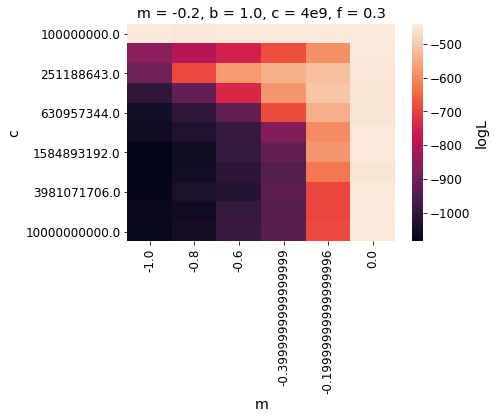

In [358]:
piv = model_logLs.groupby(['m','c']).median('logL').reset_index().groupby(['m','c']).median('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
plt.show()

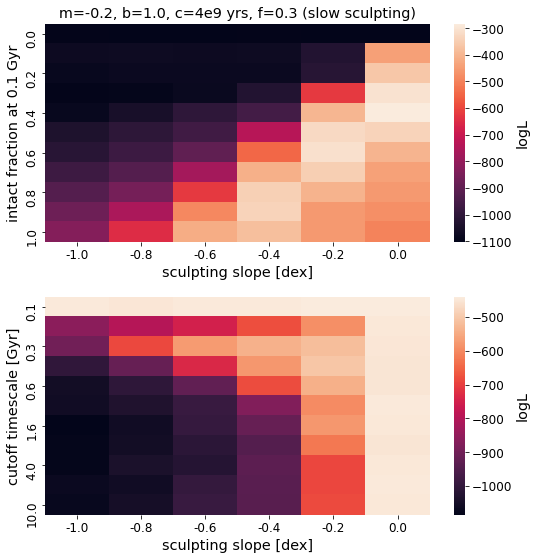

In [516]:
f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))
f.tight_layout(pad=3.)

### 1
piv = model_logLs.groupby(['m','b']).median('logL').reset_index()
piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood

#fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax1)
ax1.set_yticks(ax1.get_yticks()[::2]) # sample every other tick, for cleanness
ax1.set_title('m=-0.2, b=1.0, c=4e9 yrs, f=0.3 (slow sculpting)')
ax1.set(ylabel='intact fraction at 0.1 Gyr')
ax1.set(xlabel='sculpting slope [dex]')

### 2
piv = model_logLs.groupby(['m','c']).median('logL').reset_index()
piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood

sns.heatmap(piv, yticklabels=np.round(model_logLs.c.unique()/1e9,1), xticklabels=model_logLs.m.unique().round(1), 
            cbar_kws={'label': 'logL'}, ax=ax2)
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax2.set_yticks(ax2.get_yticks()[::2]) # sample every other tick, for cleanness
ax2.set(ylabel='cutoff timescale [Gyr]')
ax2.set(xlabel='sculpting slope [dex]')
#ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#ax2.yaxis.set_major_formatter(tick.FormatStrFormatter('%2.2e'))

plt.savefig(path+'figures/inj-rec-slow-2d.png', facecolor='white', bbox_inches='tight')
plt.show()

Even within the m=-0.2 column, the best cutoff timescales are sub-Gyr, with the ground truth of 4 Gyrs being relatively disfavored. Similarly, the ground truth initial intact fraction of 1.0 is only moderately favored compared to 0.5, even within the m=-0.2 column. 

Finally, let's plot good, best, and ground truth models.

In [514]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(np.round(model_logLs.m, 1) == -0.2) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
#delta_logL = best_logL - ground_truth.logL.to_list()[0]
delta_logL = np.std(recovery.loc[(np.round(recovery.ms, 1) == -0.2) & (np.round(recovery.bs,1) == 1.) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)].logLs)

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f  \
6842  0.0  0.7  251188643.0  0.3   

                                                     tm       logL  
6842  [672.3, 255.89999999999998, 122.1, 45.0, 14.39... -19.037579  
Ground truth:          m    b             c    f  \
6022 -0.2  1.0  3.981072e+09  0.3   

                                                     tm       logL  
6022  [682.1999999999999, 253.2, 126.3, 59.4, 16.5, ... -19.125226  
Some models between best model and ground truth: 
        m    b            c    f  \
662  -1.0  0.6  100000000.0  0.3   
772  -1.0  0.7  100000000.0  0.3   
882  -1.0  0.8  100000000.0  0.3   
1122 -1.0  1.0  251188643.0  0.3   
1872 -0.8  0.6  100000000.0  0.3   

                                                     tm       logL  
662              [687.9, 225.6, 105.6, 40.5, 10.2, 0.0] -24.131664  
772   [689.1, 274.2, 129.29999999999998, 55.19999999... -19.783823  
882   [702.0, 290.7, 127.8, 48.3, 13.799999999999999... -22.218298  
1122 

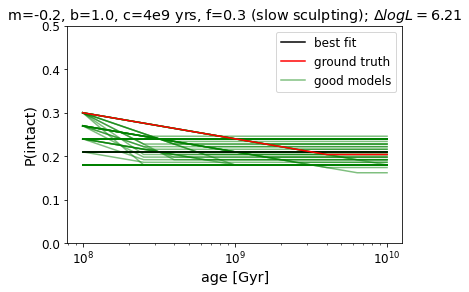

In [515]:
x = np.logspace(8, 10, 1000)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm=-0.2, b=1.0, c=4e9 yrs, f=0.3 (slow sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.savefig(path+'figures/inj-rec-slow-models.png', facecolor='white', bbox_inches='tight')

plt.show()

Sarah wanted to know whether the logL distributions were flat when we subset by good models (they should). 

In [340]:
good_models

,m,b,c,f,tm,logL
662,-1.0,0.6,1.000000e+08,0.3,"[687.9, 225.6, 105.6, 40.5, 10.2, 0.0]",-24.131664
772,-1.0,0.7,1.000000e+08,0.3,"[689.1, 274.2, 129.29999999999998, 55.19999999...",-19.783823
882,-1.0,0.8,1.000000e+08,0.3,"[702.0, 290.7, 127.8, 48.3, 13.799999999999999...",-22.218298
1122,-1.0,1.0,2.511886e+08,0.3,"[680.6999999999999, 232.2, 105.0, 41.1, 12.9, ...",-23.596866
1872,-0.8,0.6,1.000000e+08,0.3,"[715.5, 215.7, 113.1, 45.3, 10.799999999999999...",-24.018794
...,...,...,...,...,...,...
6992,0.0,0.8,1.584893e+09,0.3,"[703.8, 288.59999999999997, 135.29999999999998...",-22.913250
7002,0.0,0.8,2.511886e+09,0.3,"[705.6, 285.3, 146.7, 63.3, 17.099999999999998...",-23.031807
7012,0.0,0.8,3.981072e+09,0.3,"[712.8, 285.0, 144.6, 56.699999999999996, 16.2...",-22.392215
7022,0.0,0.8,6.309573e+09,0.3,"[692.4, 297.0, 138.29999999999998, 55.8, 14.1,...",-22.439381


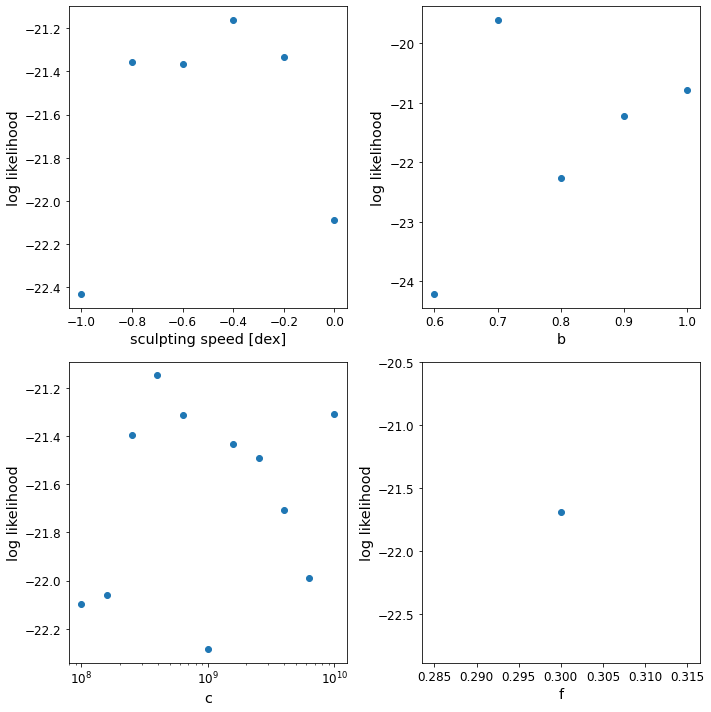

In [335]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.m, 1) == np.round(cube[0], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.b,1) == np.round(cube[1], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = good_models.loc[(np.round(good_models.c,0) == np.round(cube[2], 0))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = good_models.loc[(np.round(good_models.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()